In [59]:
import os
import math
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [60]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
BATCH_SIZE = 30
LEARNING_RATE = 0.003
IMG_SIZE = 64
CONV_SIZE = math.floor((((IMG_SIZE-2)/2)-2)/2)

data_path = os.path.dirname(os.getcwd()) + "\_datasets"
TRAIN_DATA_PATH = data_path + "\\flowers_train_test\\train"
TEST_DATA_PATH = data_path + "\\flowers_train_test\\test"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [61]:
train_data_loader

In [62]:
print(len(train_data))
print(len(test_data))
train_data.classes

158
510


['daisy']

In [63]:
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='test loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('results/plot_loss.png')
    plt.close()
    print("Loss plot saved.")

def plot_accu(train_accuracy, val_accuracy):
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(val_accuracy, label='test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.legend()
    plt.savefig('results/plot_accu.png')
    plt.close()
    print("Accu plot saved.")

In [64]:
class Flower_Net_1(nn.Module):
    def __init__(self):
        super(Flower_Net_1,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,8,kernel_size=3,padding=1),nn.AvgPool2d(kernel_size=3,padding=1))
        self.layer2 = nn.Sequential(nn.Conv2d(8,16,kernel_size=3,padding=1),nn.MaxPool2d(kernel_size=3,padding=1))
        self.layer3 = nn.Sequential(nn.Conv2d(16,8,kernel_size=3,padding=1),nn.MaxPool2d(kernel_size=3,padding=1))
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        out = self.flatten(x)
        return out

class Flower_Net_2(nn.Module):
    def __init__(self):
        super(Flower_Net_2,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,16,kernel_size=3,padding=1),nn.AvgPool2d(kernel_size=3,padding=1))
        self.layer2 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),nn.MaxPool2d(kernel_size=3,padding=1))
        self.layer3 = nn.Sequential(nn.Conv2d(32,8,kernel_size=3,padding=1),nn.MaxPool2d(kernel_size=3,padding=1))
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        out = self.flatten(x)
        return out
    
class Flower_Net_3(nn.Module):
    def __init__(self):
        super(Flower_Net_3,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,32,kernel_size=3,padding=1),nn.AvgPool2d(kernel_size=3,padding=1))
        self.layer2 = nn.Sequential(nn.Conv2d(32,8,kernel_size=3,padding=1),nn.MaxPool2d(kernel_size=3,padding=1))
        self.layer3 = nn.Sequential(nn.Conv2d(8,8,kernel_size=3,padding=1),nn.MaxPool2d(kernel_size=3,padding=1))
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        out = self.flatten(x)
        return out

class ensemble_Net(nn.Module):    
    def __init__(self):
        super(ensemble_Net,self).__init__()
        f1 = Flower_Net_1()
        f2 = Flower_Net_2()
        f3 = Flower_Net_3()
        self.e1 = f1
        self.e2 = f2
        self.e3 = f3
        self.avgpool = nn.AvgPool1d(kernel_size=1)
        self.fc1 = nn.Linear(216,30)
        self.fc2 = nn.Linear(30,5)
    
    def forward(self,x):
        o1 = self.e1(x)
    
        o2 = self.e2(x)
        o3 = self.e3(x)
        x = torch.cat((o1,o2,o3),dim=1)
        #print(x.size())
        x = self.fc1(x)
        out = self.fc2(x)
        
        return out
    
        
model = ensemble_Net()

In [65]:
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=LEARNING_RATE)

In [66]:
import torch.nn.functional as F 

# train_data_loader, test_data_loader = data_loader(TRAIN_DATA_PATH, TEST_DATA_PATH)
model = ensemble_Net()
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE)

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(EPOCHS):

    start = time.time()

    train_epoch_loss = []
    train_epoch_accuracy = []
    val_epoch_loss = []
    val_epoch_accuracy = []

    for images, labels in train_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        preds = model(images)

        acc = calc_accuracy(labels.cpu(), preds.cpu())
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)

    for images, labels in test_data_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        loss = criterion(preds, labels)

        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)

    end = time.time()

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    print("@@ Epoch {} = {}s".format(epoch, int(end - start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 2)))
    print("Train Accu = {} %".format(round(train_epoch_accuracy), 2))
    print("Valid Loss = {}".format(round(val_epoch_loss, 2)))
    print("Valid Accu = {} % \n".format(round(val_epoch_accuracy), 2))

plot_loss(train_loss, val_loss)
plot_accu(train_accuracy, val_accuracy)

@@ Epoch 0 = 4s
Train Loss = 0.77
Train Accu = 83 %
Valid Loss = 11.62
Valid Accu = 20 % 

@@ Epoch 1 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 55.85
Valid Accu = 20 % 

@@ Epoch 2 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 105.0
Valid Accu = 20 % 

@@ Epoch 3 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 139.92
Valid Accu = 20 % 

@@ Epoch 4 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 157.89
Valid Accu = 20 % 

@@ Epoch 5 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 162.86
Valid Accu = 20 % 

@@ Epoch 6 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 159.66
Valid Accu = 20 % 

@@ Epoch 7 = 5s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 151.98
Valid Accu = 20 % 

@@ Epoch 8 = 5s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 142.23
Valid Accu = 20 % 

@@ Epoch 9 = 4s
Train Loss = 0.0
Train Accu = 100 %
Valid Loss = 131.79
Valid Accu = 20 % 

Loss plot saved.
Accu plot saved.


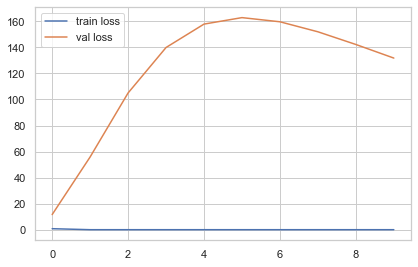

In [68]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()

In [ ]:
plt.plot(train_correct, label='train correct')
plt.plot(test_correct, label='test correct')
plt.legend()